In [50]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# <u> NACEP </u>
## 2015-16 CRDC
## AP- & DE-Only Schools:   Flag Analysis
#### Alijah O'Connor - 2018
------------------------------------------------------------------------------------
---

Uses the filtered dataset (representing 'Traditional High Schools') and crdc-averaged total enrollments (representing HS Studnets in each school) to determine the breakdown of schools and high school enrollments in Schools that either (1) Only offer DE, (2) Only offer AP, (3) Offer Both, or (4) Don't offer either.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected = True)

%matplotlib inline
sns.set_style('whitegrid')
plt.rc('axes', titlesize = 14, titleweight = 'bold', labelweight = 'bold')

In [2]:
hs_uncleaned = pd.read_csv('../filtered_data/04_filter_final.csv', dtype = {'LEAID':np.object})

**Setting up Enrollments**

In [3]:
def missing_value_mapper(value):
    """Converts any negative number into 0, as these negative numbers represent missing/null values"""
    if isinstance(value, int):
        if value < 0:
            return 0
    return value

In [4]:
from my_functions.extra_functions import hs_enrollment_averager
hs = hs_uncleaned.copy()
hs = hs.applymap(missing_value_mapper)
hs['total_enrollment'] = hs['TOT_ENR_M'] + hs['TOT_ENR_F']
hs['hs_total_enrollment'] = hs_enrollment_averager(hs) 

In [5]:
def ap_only(ap_flag, de_flag):
    if ap_flag == 'Yes' and de_flag == 'No':
        return 1
    return 0

def de_only(ap_flag, de_flag):
    if ap_flag =='No' and de_flag == 'Yes':
        return 1
    return 0

def neither(ap_flag, de_flag):
    if ap_flag == 'No' and de_flag == 'No':
        return 1
    return 0

def both(ap_flag, de_flag):
    if ap_flag == 'Yes' and de_flag == 'Yes':
        return 1
    return 0

In [6]:
hs['ap_only'] = hs.apply(lambda row: ap_only(row['SCH_APENR_IND'],row['SCH_DUAL_IND']), axis=1)
hs['de_only'] = hs.apply(lambda row: de_only(row['SCH_APENR_IND'],row['SCH_DUAL_IND']), axis=1)
hs['neither_ap_de'] = hs.apply(lambda row: neither(row['SCH_APENR_IND'],row['SCH_DUAL_IND']), axis=1)
hs['both_ap_de'] = hs.apply(lambda row: both(row['SCH_APENR_IND'],row['SCH_DUAL_IND']), axis=1)

**Set up DataFrames**

In [7]:
hs_ap_only = hs.copy()
hs_ap_only = hs_ap_only[hs_ap_only.ap_only == 1]

In [8]:
hs_de_only = hs.copy()
hs_de_only = hs_de_only[hs_de_only.de_only == 1]

In [9]:
hs_neither_ap_de = hs.copy()
hs_neither_ap_de = hs_neither_ap_de[hs_neither_ap_de.neither_ap_de == 1]

In [10]:
hs_both_ap_de = hs.copy()
hs_both_ap_de = hs_both_ap_de[hs_both_ap_de.both_ap_de == 1]

**Additional Helper Functions**

In [11]:
from my_functions.extra_functions import de_ap_enrollments, add_de_ap_pcts

# National

### -- Schools

In [12]:
num_total_schools = len(hs)
num_de_only_schools = len(hs_de_only)
num_ap_only_schools = len(hs_ap_only)
num_both_schools = len(hs_both_ap_de)
num_neither_schools = len(hs_neither_ap_de)

national_school_breakdown = pd.DataFrame({'Number of Schools': 
                                         [num_de_only_schools, num_ap_only_schools,
                                          num_both_schools, num_neither_schools, num_total_schools]}, 
                                        index = ['DE_Only', 'AP_Only', 'Both_AP_DE', 'Neither_AP_DE', 'Total']).T

national_school_breakdown_with_pcts = add_de_ap_pcts(national_school_breakdown)
national_school_breakdown_with_pcts

,DE_Only,DE_Only %,AP_Only,AP_Only %,Neither_AP_DE,Neither_AP_DE %,Both_AP_DE,Both_AP_DE %,Total
Number of Schools,3872,20.7,3298,17.7,2039,10.9,9458,50.7,18667


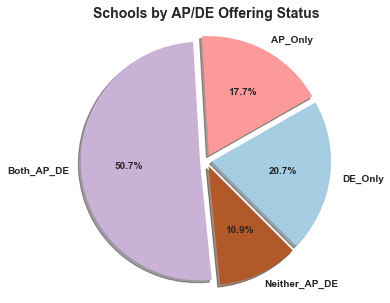

In [13]:
with plt.rc_context({'lines.linewidth': 5, 'font.weight':'bold'}):
    national_school_breakdown.T.drop('Total').plot.pie(y='Number of Schools',autopct='%1.1f%%', 
                            startangle = -45, shadow = True, explode = [.05 for i in range(len(national_school_breakdown.T)-1)],
                            colormap='Paired', figsize = (5,5))
    plt.title('Schools by AP/DE Offering Status')
    plt.legend([])
    plt.ylabel('')
    plt.xticks(fontdict={'fontweight':'bold'})
    plt.axis('equal')

### -- Enrollments

In [14]:
de_ap_enrollments(hs_de_only, hs_ap_only, hs_neither_ap_de, hs_both_ap_de)

,DE_Only_hs_students,DE_Only %,AP_Only_hs_students,AP_Only %,Neither_AP_DE_hs_students,Neither_AP_DE %,Both_AP_DE_hs_students,Both_AP_DE %,Total
HS Enrollments,964677,6.9,3078010,21.9,410962,2.9,9616360,68.3,14070009


## - By Size

In [15]:
from my_functions.extra_functions import school_sizer
hs_ap_only['size_group'] = hs_ap_only['hs_total_enrollment'].apply(lambda x: school_sizer(x))
hs_de_only['size_group'] = hs_de_only['hs_total_enrollment'].apply(lambda x: school_sizer(x))
hs_neither_ap_de['size_group'] = hs_neither_ap_de['hs_total_enrollment'].apply(lambda x: school_sizer(x))
hs_both_ap_de['size_group'] = hs_both_ap_de['hs_total_enrollment'].apply(lambda x: school_sizer(x))

In [16]:
hs_de_only_size = hs_de_only.groupby('size_group')['LEAID'].count()
hs_de_only_size.rename('DE_Only', inplace=True);

In [17]:
hs_ap_only_size = hs_ap_only.groupby('size_group')['LEAID'].count()
hs_ap_only_size.rename('AP_Only', inplace=True);

In [18]:
hs_neither_ap_de_size = hs_neither_ap_de.groupby('size_group')['LEAID'].count()
hs_neither_ap_de_size.rename('Neither_AP_DE', inplace=True);

In [19]:
hs_both_ap_de_size = hs_both_ap_de.groupby('size_group')['LEAID'].count()
hs_both_ap_de_size.rename('Both_AP_DE', inplace=True);

### -- Schools

In [20]:
by_size = pd.concat([hs_de_only_size, hs_ap_only_size, hs_neither_ap_de_size, hs_both_ap_de_size], axis = 1)
by_size['Total'] = by_size['DE_Only'] + by_size['AP_Only'] + by_size['Both_AP_DE'] + by_size['Neither_AP_DE']
by_size = by_size.rename({1:'<100', 2:'100-499', 3:'500-1199', 4:'>1200'})

by_size = add_de_ap_pcts(by_size)
by_size

,DE_Only,DE_Only %,AP_Only,AP_Only %,Neither_AP_DE,Neither_AP_DE %,Both_AP_DE,Both_AP_DE %,Total
size_group,,,,,,,,,
<100,1122,47.6,124,5.3,903,38.3,209,8.9,2358
100-499,2313,31.3,1188,16.1,977,13.2,2912,39.4,7390
500-1199,375,8.3,1001,22.0,133,2.9,3034,66.8,4543
>1200,62,1.4,985,22.5,26,0.6,3303,75.5,4376


### -- Enrollments

In [21]:
enrollments_by_size = de_ap_enrollments(hs_de_only, hs_ap_only, hs_neither_ap_de, hs_both_ap_de, groupby_field = 'size_group')
enrollments_by_size = enrollments_by_size.rename({1:'<100', 2:'100-499', 3:'500-1199', 4:'>1200'})
enrollments_by_size

,DE_Only_hs_students,DE_Only %,AP_Only_hs_students,AP_Only %,Neither_AP_DE_hs_students,Neither_AP_DE %,Both_AP_DE_hs_students,Both_AP_DE %,Total
size_group,,,,,,,,,
<100,68681,52.1,7855,6.0,40858,31.0,14325,10.9,131719
100-499,542568,26.7,369623,18.2,226904,11.2,890017,43.9,2029112
500-1199,255761,7.0,794731,21.9,95076,2.6,2491421,68.5,3636989
>1200,97667,1.2,1905801,23.0,48124,0.6,6220597,75.2,8272189


## - By Locale

In [22]:
locale_map = {11: 'City', 12: 'City', 13: 'City', 14: 'City',
              21: 'Suburban', 22: 'Suburban', 23: 'Suburban', 24: 'Suburban',
              31: 'Town', 32: 'Town', 33: 'Town', 34: 'Town',
              41: 'Rural', 42: 'Rural', 43: 'Rural', 44: 'Rural'}

In [23]:
hs_de_only['locale'] = hs_de_only['LOCALE15'].map(locale_map)
hs_ap_only['locale'] = hs_ap_only['LOCALE15'].map(locale_map)
hs_neither_ap_de['locale'] = hs_neither_ap_de['LOCALE15'].map(locale_map)
hs_both_ap_de['locale'] = hs_both_ap_de['LOCALE15'].map(locale_map)

In [24]:
hs_de_only_locale = hs_de_only.groupby('locale')['LEAID'].count()
hs_de_only_locale.rename('DE_Only', inplace=True);

In [25]:
hs_ap_only_locale = hs_ap_only.groupby('locale')['LEAID'].count()
hs_ap_only_locale.rename('AP_Only', inplace=True);

In [26]:
hs_neither_ap_de_locale = hs_ap_only.groupby('locale')['LEAID'].count()
hs_neither_ap_de_locale.rename('Neither_AP_DE', inplace=True);

In [27]:
hs_both_ap_de_locale = hs_both_ap_de.groupby('locale')['LEAID'].count()
hs_both_ap_de_locale.rename('Both_AP_DE', inplace=True);

### -- Schools

In [28]:
by_locale = pd.concat([hs_de_only_locale, hs_ap_only_locale, hs_neither_ap_de_locale, hs_both_ap_de_locale], axis = 1)
by_locale['Total'] = by_locale['DE_Only'] + by_locale['AP_Only'] + by_locale['Both_AP_DE'] + by_locale['Neither_AP_DE']

by_locale = add_de_ap_pcts(by_locale)
by_locale

,DE_Only,DE_Only %,AP_Only,AP_Only %,Neither_AP_DE,Neither_AP_DE %,Both_AP_DE,Both_AP_DE %,Total
locale,,,,,,,,,
City,335,7.2,1186,25.4,1186,25.4,1966,42.1,4673
Rural,2718,37.6,692,9.6,692,9.6,3135,43.3,7237
Suburban,268,5.1,1067,20.3,1067,20.3,2858,54.3,5260
Town,551,20.0,353,12.8,353,12.8,1499,54.4,2756


### -- Enrollments

In [29]:
de_ap_enrollments(hs_de_only, hs_ap_only, hs_neither_ap_de, hs_both_ap_de, groupby_field = 'locale')

,DE_Only_hs_students,DE_Only %,AP_Only_hs_students,AP_Only %,Neither_AP_DE_hs_students,Neither_AP_DE %,Both_AP_DE_hs_students,Both_AP_DE %,Total
locale,,,,,,,,,
City,138271,3.4,1134401,28.1,167061,4.1,2600916,64.4,4040649
Rural,483935,17.4,336659,12.1,104517,3.8,1857241,66.8,2782352
Suburban,125741,2.2,1365282,24.2,83803,1.5,4073152,72.1,5647978
Town,216730,13.6,241668,15.1,55581,3.5,1085051,67.9,1599030


## - By Ethncity 

In [30]:
hs_de_only['pct_eth'] = (hs_de_only['total_enrollment'] - hs_de_only['SCH_ENR_WH_F'] - hs_de_only['SCH_ENR_WH_M']) / hs_de_only['total_enrollment'] 
hs_ap_only['pct_eth'] = (hs_ap_only['total_enrollment'] - hs_ap_only['SCH_ENR_WH_F'] - hs_ap_only['SCH_ENR_WH_M']) / hs_ap_only['total_enrollment'] 
hs_neither_ap_de['pct_eth'] = (hs_neither_ap_de['total_enrollment'] - hs_neither_ap_de['SCH_ENR_WH_F'] - hs_neither_ap_de['SCH_ENR_WH_M']) / hs_neither_ap_de['total_enrollment'] 
hs_both_ap_de['pct_eth'] = (hs_both_ap_de['total_enrollment'] - hs_both_ap_de['SCH_ENR_WH_F'] - hs_both_ap_de['SCH_ENR_WH_M']) / hs_both_ap_de['total_enrollment'] 

from my_functions.extra_functions import eth_grouper

hs_de_only['eth_quintile'] = hs_de_only['pct_eth'].apply(lambda x: eth_grouper(x))
hs_ap_only['eth_quintile'] = hs_ap_only['pct_eth'].apply(lambda x: eth_grouper(x))
hs_neither_ap_de['eth_quintile'] = hs_neither_ap_de['pct_eth'].apply(lambda x: eth_grouper(x))
hs_both_ap_de['eth_quintile'] = hs_both_ap_de['pct_eth'].apply(lambda x: eth_grouper(x))

In [31]:
hs_de_only_eth = hs_de_only.groupby('eth_quintile')['LEAID'].count()
hs_de_only_eth.rename('DE_Only', inplace = True);

In [32]:
hs_ap_only_eth = hs_ap_only.groupby('eth_quintile')['LEAID'].count()
hs_ap_only_eth.rename('AP_Only', inplace = True);

In [33]:
hs_neither_ap_de_eth = hs_neither_ap_de.groupby('eth_quintile')['LEAID'].count()
hs_neither_ap_de_eth.rename('Neither_AP_DE', inplace = True);

In [34]:
hs_both_ap_de_eth = hs_both_ap_de.groupby('eth_quintile')['LEAID'].count()
hs_both_ap_de_eth.rename('Both_AP_DE', inplace = True);

### -- Schools

In [35]:
by_eth = pd.concat([hs_de_only_eth, hs_ap_only_eth, hs_neither_ap_de_eth, hs_both_ap_de_eth], axis = 1)
by_eth['Total'] = by_eth['DE_Only'] + by_eth['AP_Only'] + by_eth['Both_AP_DE'] + by_eth['Neither_AP_DE']
by_eth = by_eth.rename({1:'0-20%', 2:'21-40%', 3:'41-60%', 4:'61-80%', 5:'81-100%'})

by_eth = add_de_ap_pcts(by_eth)
by_eth

,DE_Only,DE_Only %,AP_Only,AP_Only %,Neither_AP_DE,Neither_AP_DE %,Both_AP_DE,Both_AP_DE %,Total
eth_quintile,,,,,,,,,
0-20%,2134,30.0,842,11.8,603,8.5,3543,49.7,7122
21-40%,699,20.0,508,14.5,310,8.9,1985,56.7,3502
41-60%,349,14.5,422,17.5,237,9.8,1406,58.2,2414
61-80%,239,13.1,413,22.6,218,12.0,954,52.3,1824
81-100%,451,11.9,1113,29.3,671,17.6,1570,41.3,3805


### -- Enrollments

In [36]:
enrollment_by_eth = de_ap_enrollments(hs_de_only, hs_ap_only, hs_neither_ap_de, hs_both_ap_de, groupby_field = 'eth_quintile')
enrollment_by_eth = enrollment_by_eth.rename({1:'0-20%', 2:'21-40%', 3:'41-60%', 4:'61-80%', 5:'81-100%'})
enrollment_by_eth

,DE_Only_hs_students,DE_Only %,AP_Only_hs_students,AP_Only %,Neither_AP_DE_hs_students,Neither_AP_DE %,Both_AP_DE_hs_students,Both_AP_DE %,Total
eth_quintile,,,,,,,,,
0-20%,475225,13.6,539481,15.4,97349,2.8,2383160,68.2,3495215
21-40%,169099,5.7,483055,16.4,55650,1.9,2238563,76.0,2946367
41-60%,102395,4.2,508840,20.8,44633,1.8,1787643,73.2,2443511
61-80%,79672,4.2,519079,27.1,47637,2.5,1266426,66.2,1912814
81-100%,138286,4.2,1027555,31.4,165693,5.1,1940568,59.3,3272102


# By State

In [37]:
"""Which states have many schools offering DE but not AP?"""
hs_de_only_state = hs_de_only.groupby('LEA_STATE')['LEAID'].count().rename('DE_Only')

In [38]:
"""Which states have many schools offering AP but not DE?"""
hs_ap_only_state = hs_ap_only.groupby('LEA_STATE')['LEAID'].count().rename('AP_Only')

In [39]:
"""Which states have many schools NOT offering AP or DE?"""
hs_neither_ap_de_state = hs_neither_ap_de.groupby('LEA_STATE')['LEAID'].count().rename('Neither_AP_DE')

In [40]:
"""Which states have many schools offering AP and DE?"""
hs_both_ap_de_state = hs_both_ap_de.groupby('LEA_STATE')['LEAID'].count().rename('Both_AP_DE')

### -- Schools

In [41]:
by_state = pd.concat([hs_de_only_state, hs_ap_only_state, hs_neither_ap_de_state, hs_both_ap_de_state], axis = 1)
by_state = by_state.fillna(0).astype(int)
by_state['Total'] = by_state['DE_Only'] + by_state['AP_Only'] + by_state['Both_AP_DE'] + by_state['Neither_AP_DE']

by_state = add_de_ap_pcts(by_state)
display(by_state.sort_values('Neither_AP_DE %', ascending = False))

print('Reads like: ' + str(by_state.at['AK', 'DE_Only']) + ' Schools in AK Only offer DE, making up '
      + str(by_state.at['AK', 'DE_Only %']) + '% of the total traditional High Schools in the State')

,DE_Only,DE_Only %,AP_Only,AP_Only %,Neither_AP_DE,Neither_AP_DE %,Both_AP_DE,Both_AP_DE %,Total
AK,68,28.0,13,5.3,133,54.7,29,11.9,243
AZ,58,14.4,69,17.2,153,38.1,122,30.3,402
MT,44,26.3,22,13.2,46,27.5,55,32.9,167
WY,31,40.8,2,2.6,16,21.1,27,35.5,76
MN,154,35.6,47,10.9,87,20.1,144,33.3,432
OH,232,25.9,51,5.7,162,18.1,450,50.3,895
OK,125,28.1,56,12.6,80,18.0,184,41.3,445
MS,57,21.7,24,9.1,45,17.1,137,52.1,263
OR,85,31.5,39,14.4,46,17.0,100,37.0,270
NV,17,14.8,44,38.3,19,16.5,35,30.4,115


Reads like: 68 Schools in AK Only offer DE, making up 28.0% of the total traditional High Schools in the State


### -- Enrollments

In [42]:
enrollments_by_state = de_ap_enrollments(hs_de_only, hs_ap_only, hs_neither_ap_de, hs_both_ap_de, groupby_field = 'LEA_STATE')
display(enrollments_by_state)

print('Reads like: There are ' + str(enrollments_by_state.at['AK', 'DE_Only_hs_students']) 
      + ' High School Students in AK schools that only offer DE, making up '
      + str(enrollments_by_state.at['AK', 'DE_Only %']) + '% of the total High School Students in the State')

,DE_Only_hs_students,DE_Only %,AP_Only_hs_students,AP_Only %,Neither_AP_DE_hs_students,Neither_AP_DE %,Both_AP_DE_hs_students,Both_AP_DE %,Total
AK,4060,11.7,8650,24.9,4120,11.9,17872,51.5,34702
AL,30517,14.8,18741,9.1,8398,4.1,148340,72.0,205996
AR,2079,1.6,28372,22.1,2178,1.7,95841,74.6,128470
AZ,14986,4.8,73449,23.4,29503,9.4,196319,62.5,314257
CA,18812,1.1,1062092,60.9,53029,3.0,609230,34.9,1743163
CO,17606,7.4,26006,10.9,3582,1.5,190443,80.1,237637
CT,10819,6.7,51948,32.0,3091,1.9,96514,59.4,162372
DC,0,0.0,11954,82.3,153,1.1,2423,16.7,14530
DE,4801,12.7,9917,26.2,307,0.8,22833,60.3,37858
FL,18094,2.4,26677,3.5,6336,0.8,714567,93.3,765674


Reads like: There are 4060 High School Students in AK schools that only offer DE, making up 11.7% of the total High School Students in the State


# Regional

In [43]:
"""
1:  Middle States Commission on Higher Education - New York, New Jersey, Pennsylvania, Delaware, Maryland, the District of Columbia

2:  New England Association of Schools and Colleges - Connecticut, Maine, Massachusetts, New Hampshire, Rhode Island, and Vermont

3:  Higher Learning Commission - Arkansas, Arizona, Colorado, Iowa, Illinois, Indiana, Kansas, Michigan, Minnesota, Missouri, 
    North Dakota, Nebraska, New Mexico, Ohio, Oklahoma, South Dakota, Wisconsin, West Virginia, and Wyoming

4:  Northwest Commission on Colleges and Universities - Alaska, Idaho, Montana, Nevada, Oregon, Utah, and Washington

5:  Southern Association of Colleges and Schools - Alabama, Florida, Georgia, Kentucky, Louisiana, Mississippi, 
    North Carolina, South Carolina, Tennessee, Texas and Virginia

6:  Western Association of Schools and Colleges - California, Hawaii
"""

from my_functions.extra_functions import region_mapper
hs_de_only['region_accred'] = hs_de_only['LEA_STATE'].apply(lambda x: region_mapper(x))
hs_ap_only['region_accred'] = hs_ap_only['LEA_STATE'].apply(lambda x: region_mapper(x))
hs_neither_ap_de['region_accred'] = hs_neither_ap_de['LEA_STATE'].apply(lambda x: region_mapper(x))
hs_both_ap_de['region_accred'] = hs_both_ap_de['LEA_STATE'].apply(lambda x: region_mapper(x))

In [44]:
hs_de_only_region = hs_de_only.groupby('region_accred')['LEAID'].count()
hs_de_only_region.rename('DE_Only', inplace=True);

In [45]:
hs_ap_only_region = hs_ap_only.groupby('region_accred')['LEAID'].count()
hs_ap_only_region.rename('AP_Only', inplace=True);

In [46]:
hs_neither_ap_de_region = hs_neither_ap_de.groupby('region_accred')['LEAID'].count()
hs_neither_ap_de_region.rename('Neither_AP_DE', inplace=True);

In [47]:
hs_both_ap_de_region = hs_both_ap_de.groupby('region_accred')['LEAID'].count()
hs_both_ap_de_region.rename('Both_AP_DE', inplace=True);

### -- Schools

In [48]:
by_region = pd.concat([hs_de_only_region, hs_ap_only_region, hs_neither_ap_de_region, hs_both_ap_de_region], axis = 1)
by_region['Total'] = by_region['DE_Only'] + by_region['AP_Only'] + by_region['Both_AP_DE'] + by_region['Neither_AP_DE']

by_region = add_de_ap_pcts(by_region)
by_region

,DE_Only,DE_Only %,AP_Only,AP_Only %,Neither_AP_DE,Neither_AP_DE %,Both_AP_DE,Both_AP_DE %,Total
region_accred,,,,,,,,,
HLC,2172,30.4,661,9.2,899,12.6,3424,47.8,7156
MSCHE,195,7.5,876,33.8,262,10.1,1257,48.5,2590
NEASC,79,8.9,309,35.0,69,7.8,427,48.3,884
NWCCU,381,26.0,222,15.1,322,21.9,543,37.0,1468
SACS,958,18.9,483,9.5,284,5.6,3349,66.0,5074
WASC,87,5.8,747,50.0,203,13.6,458,30.6,1495


### -- Enrollments

In [49]:
de_ap_enrollments(hs_de_only, hs_ap_only, hs_neither_ap_de, hs_both_ap_de, groupby_field = 'region_accred')

,DE_Only_hs_students,DE_Only %,AP_Only_hs_students,AP_Only %,Neither_AP_DE_hs_students,Neither_AP_DE %,Both_AP_DE_hs_students,Both_AP_DE %,Total
region_accred,,,,,,,,,
HLC,481200,11.9,492097,12.2,167841,4.1,2906734,71.8,4047872
MSCHE,71589,3.5,649594,32.2,81571,4.0,1213937,60.2,2016691
NEASC,31856,5.2,251008,40.8,15701,2.6,316730,51.5,615295
NWCCU,91178,10.2,214744,23.9,30491,3.4,561358,62.5,897771
SACS,268005,5.7,408475,8.7,61992,1.3,3960388,84.3,4698860
WASC,20849,1.2,1062092,59.2,53366,3.0,657213,36.6,1793520
